# Regional network (ISC) locations of Western US events

In [1]:
%pylab inline
import requests

Populating the interactive namespace from numpy and matplotlib


Query the IRIS server for events with lon (-126, 100), lat (33, 49), between Feb 1 2006 and Mar 31 2008:

In [5]:
"""
url = "http://isc-mirror.iris.washington.edu/cgi-bin/web-db-v4?request=COMPREHENSIVE&out_format=ISF&searchshape=RECT&bot_lat=33&top_lat=49&left_lon=-126&right_lon=-100&start_year=2006&start_month=2&start_day=1&start_time=00%3A00%3A00&end_year=2008&end_month=3&end_day=31&end_time=00%3A00%3A00&include_magnitudes=on"
r = requests.get(url)
with open("western_isc_page", 'w') as f:
    f.write(r.content)
with open("western_isc_page", 'r') as f:
    page = f.read()
    
idx1 = page.index("<pre>")+6
idx2 = page.index("STOP")
csvpage = page[idx1:idx2]

with open("western_isc_csvpage", 'w') as f:
    f.write(csvpage)"""
with open("western_isc_csvpage", 'r') as f:
    csvpage = f.read()

IOError: [Errno 2] No such file or directory: 'western_isc_csvpage'

In [8]:
evs = csvpage.split("\n\n")[:-1]
print len(evs)
print evs[1]

2325
2006/02/03 01:47:46.18   0.28 0.961  47.9736 -122.4078 3.322 1.992  98  20.3  3.41  125   96  35   0.29  68.02 m i fe ISCJB      9954452
2006/02/03 01:47:46.73        0.220  47.9508 -122.3948   0.1            33.0         63   63  52   0.05               PNSN       7870279
2006/02/03 01:47:46.73        0.430  47.9510 -122.3945                  33.0f        24   19                       fe PGC        8224793
2006/02/03 01:47:47.00f              47.9500 -122.3990f                 28.8f                 59   0.48  15.22     fe NEIC       9814732
2006/02/03 01:47:48.55   3.96 0.780  47.8014 -122.1905  29.3  15.7 124  34.8  47.1    7      147   3.43  68.18     uk IDC        8217342
2006/02/03 01:47:46.46   0.40 0.948  47.9709 -122.4313 3.210 2.139  90  17.6  3.36  125   96  36   0.30  68.03 m i fe ISC        9824363
 (#PRIME)
mb     3.4        3 ISCJB      9954452
MD     3.3          PNSN       7870279
ML     3.4 0.3   27 PGC        8224793
MD     3.3          SEA        8224793
MD     

In [2]:
from datetime import datetime
import calendar 
from collections import defaultdict
TIMESTAMP_COL, TERR_COL, TRMS_COL, LON_COL, LAT_COL, SMAJ_COL, SMIN_COL, STRIKE_COL, DEPTH_COL, DERR_COL, METHOD_COL, SOURCE_COL, ISCID_COL, N_ISC_COLS = range(14)
def ev_from_line(line):
    evdate = line[:10]
    yr = int(evdate[:4])
    mo = int(evdate[5:7])
    day = int(evdate[8:])

    evtime = line[11:22]
    hr = int(evtime[:2])
    mn = int(evtime[3:5])
    ss = float(evtime[6:])
    s = int(ss)
    ms = float(ss - s)

    dt = datetime(yr, mo, day, hr, mn, s)
    ts = calendar.timegm(dt.timetuple()) + ms


    try:
        time_err = float(line[24:29])
    except:
        time_err = -1.0

    try:
        time_rms = float(line[30:35])
    except:
        time_rms = -1.0
        
    lat = float(line[36:44])
    lon = float(line[45:54])

    try:
        smaj = float(line[55:60])
        smin = float(line[61:66])
        strike = int(line[67:70])
    except:
        smaj = -1
        smin = -1
        strike = 0
    try:
        depth = float(line[71:76])
    except:
        depth = 0.0

    try:
        depth_err = float(line[78:82])
    except:
        depth_err = 0.05*depth + 1.0

    method = line[113]

    source = line[118:127].strip()

    try:
        iscid = int(line[129:136])
    except:
        iscid = -1

    return source, (ts, time_err, time_rms, lon, lat, smaj, smin, strike, depth, depth_err, method, source, iscid)

def parse_mag_line(line):
    mag_type = line[:5].strip()
    try:
        mag_value = float(line[6:10])
    except:
        mag_value = None
        
    try:
        mag_err = float(line[11:14])
    except:
        mag_err = None
    try:
        nstas = int(line[15:19])
    except:
        nstas = None
        
    author = line[20:29].strip()
    return mag_type, mag_value, mag_err, nstas, author

MAG_TYPE, MAG_VAL, MAG_ERR, MAG_NSTAS, MAG_AUTHOR = np.arange(5)

source_priority = defaultdict(int)
source_priority["ISC"]= 99
source_priority["ISCJB"]= 98
source_priority["ANF"]= 97
source_priority["NEIC"]= 96
source_priority["IDC"]= -10


def choose_origin(origins):
    if "ISC" in origins and  origins["ISC"][SMAJ_COL] > 0:
        return "ISC", origins["ISC"]
    
    sources = sorted(origins.keys())
    priorities = [source_priority[source] for source in sources]
    smajs = np.array([origins[source][SMAJ_COL]*np.abs(origins[source][SMIN_COL]) for source in sources])
    if (smajs < 0).all():
        best_idx = np.argmin(priorities)
    else:
        best_smaj = np.min(smajs[smajs > 0])
        best_idx = np.arange(len(smajs))[smajs==best_smaj][0]
    best_source = sources[best_idx]
    return best_source, origins[best_source]

def choose_mag(best_source, mags):
    
    for mag in mags:
        if "ISC" in mag[MAG_AUTHOR] and "mb" in mag[MAG_TYPE]:
            return mag
    
    # prefer the best source
    matching_mags = [mag for mag in mags if mag[MAG_AUTHOR]==best_source]
    if len(matching_mags) == 0:
        matching_mags = mags
        
    # then prefer body-wave magnitude
    mbs = [mag for mag in matching_mags if "mb" in mag[MAG_TYPE]]
    if len(mbs) > 0:
        return mbs[0] # will tend to return "mb" instead of "mb1" etc due to alphabetical sorting

    # then prefer lowest error
    errs = [mag[MAG_ERR] if mag[MAG_ERR] is not None else 100  for mag in matching_mags]
    best_err = np.argmin(errs)
    return matching_mags[best_err]

def parse_ev(ev):
    lines = ev.split("\n")
    origins = {}
    mags = []
    for l in lines:
        if "#PRIME" in l: continue
        try:
            source, evstuff = ev_from_line(l)
            origins[source] = evstuff
            continue
        except:
            pass
        try:
            magstuff = parse_mag_line(l)
            mags.append(magstuff)
        except:
            pass
    if len(mags) == 0:
        return None, None, None, False
    
    has_idc = "IDC" in origins.keys()
    source, evstuff = choose_origin(origins)
    mag = choose_mag(source, mags)
    return source, evstuff, mag, has_idc



In [4]:
parsed_evs = []
for i, ev in enumerate(evs):
    if i % 100 == 0:
        print i
    source, evstuff, mag, has_idc = parse_ev(ev)
    if source is not None:
        parsed_evs.append((source, evstuff, mag, has_idc) )
    else:
        print "no mags, skipping", i

NameError: name 'evs' is not defined

In [6]:
locs = [(evstuff[LON_COL], evstuff[LAT_COL], has_idc) for (source, evstuff, mag, has_idc) in parsed_evs]
locs_2007 = [(evstuff[LON_COL], evstuff[LAT_COL], has_idc) for (source, evstuff, mag, has_idc) in parsed_evs if evstuff[TIMESTAMP_COL] > 1170288000]
test_locs = [(evstuff[LON_COL], evstuff[LAT_COL], has_idc) for (source, evstuff, mag, has_idc) in parsed_evs if evstuff[TIMESTAMP_COL] > 1203811200]

print len(locs_2007), "evs in 2007 dataset"
print len([l for l in locs_2007 if l[2]]), "were detected by IDC"
print
print len(test_locs), "evs in test dataset"
print len([l for l in test_locs if l[2]]), "were detected by IDC"

1273 evs in 2007 dataset
323 were detected by IDC

138 evs in test dataset
44 were detected by IDC


In [ ]:
TIMESTAMP_COL, TERR_COL, TRMS_COL, LON_COL, LAT_COL, SMAJ_COL, SMIN_COL, 
STRIKE_COL, DEPTH_COL, DERR_COL, METHOD_COL, SOURCE_COL, ISCID_COL, N_ISC_COLS = range(14)


Add events to the database: (commented out since this only needs to run once)

In [19]:
"""
from sigvisa import Sigvisa
s = Sigvisa()
cursor = s.dbconn.cursor()

for (source, ev, mag, has_idc) in parsed_evs:
    mb = mag[1]
    if mb is None:
        mb = -999
    
    sql = "INSERT INTO isc_origin (lon, lat, time, depth, smaj, smin, strike, time_err, depth_err, mb, orid, auth, algorithm)"
    sql += "values (%f, %f, %f, %f, %f, %f, %d, %f, %f, %f, %d, '%s', '%s')"
    fmt = sql % (ev[LON_COL], ev[LAT_COL], ev[TIMESTAMP_COL], ev[DEPTH_COL], 
                 ev[SMAJ_COL], ev[SMIN_COL], ev[STRIKE_COL], ev[TERR_COL], 
                 ev[DERR_COL], mb, ev[ISCID_COL], ev[SOURCE_COL], ev[METHOD_COL])
    #print mag
    #print fmt
    cursor.execute(fmt)
    
cursor.close()
s.dbconn.commit()
"""

In [3]:
from sigvisa.plotting.event_heatmap import EventHeatmap


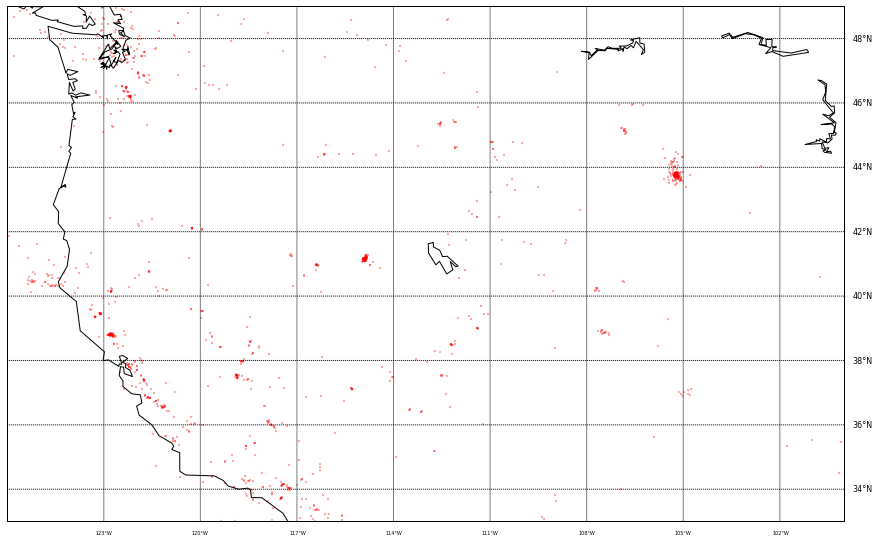

In [25]:
hm = EventHeatmap(f=None, left_lon=-126, right_lon=-100, top_lat=49, bottom_lat=33, calc=False)

f = plt.figure(figsize=(15, 15))
ax = gca()
hm.init_bmap(axes=ax, nofillcontinents=True, projection="cyl")
hm.plot_earth()

normed_locations = np.array([hm.normalize_lonlat(*location[:2]) for location in locs_2007 ])
scplot = hm.bmap.scatter(normed_locations[:, 0], normed_locations[:, 1], alpha=0.3, s=6, marker=".", color="red")

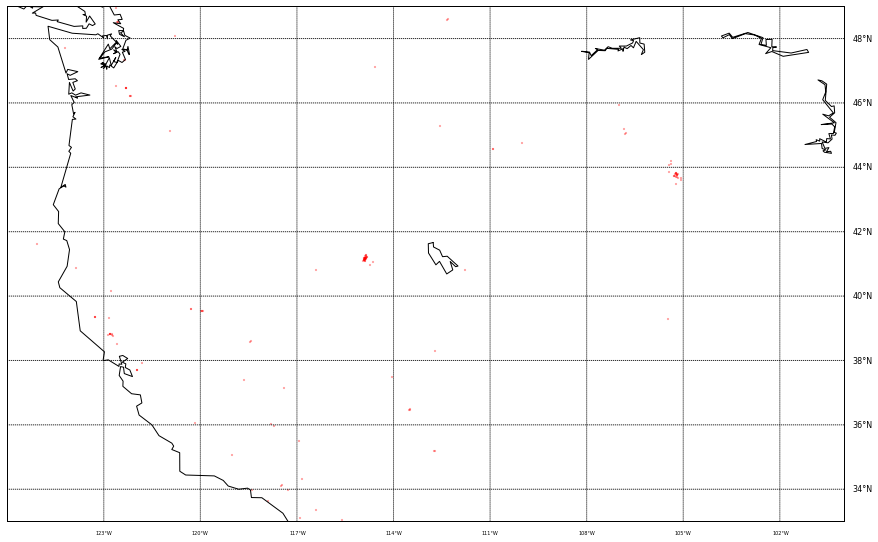

In [106]:
hm = EventHeatmap(f=None, left_lon=-126, right_lon=-100, top_lat=49, bottom_lat=33, calc=False)

f = plt.figure(figsize=(15, 15))
ax = gca()
hm.init_bmap(axes=ax, nofillcontinents=True, projection="cyl")
hm.plot_earth()

normed_locations = np.array([hm.normalize_lonlat(*location[:2]) for location in test_locs])
scplot = hm.bmap.scatter(normed_locations[:, 0], normed_locations[:, 1], alpha=0.3, s=6, marker=".", color="red")

# Timeframes for Train, Test, Validation


In [3]:
from sigvisa import Sigvisa
import numpy as np
s = Sigvisa()

from obspy.core.utcdatetime import UTCDateTime

train_start = 1167609600
train2_start = 1203603300

validation1_start = 1203624962 #  six hours after wells event
validation1_end = 1203646562 # twelve hours after wells

validation2_start = 1199145600 # jan 1 2008
validation2_end = 1203603300

test_start = 1203646562 # twelve hours after wells
short_test_end = 1203724799 # (11:59 pm feb 22)

test_week_end = 1204416000 # (00:00 pm mar 2)
test_twoweeks_end = 1204834562 # (exactly two weeks post wells, 03/06/2008 @ 8:16pm)


## Wells aftershocks

In [66]:
wells_time = 1203603362
wells_lon = 41.077
wells_lat = 114.752


wells_left = -116
wells_right = -114
wells_top = 42
wells_bottom = 40

r_wells = s.sql("select lon, lat, depth, mb, time from isc_origin where lon between %f and %f and lat between %f and %f order by time" % (wells_left, wells_right, wells_bottom, wells_top))


n_train = 0
n_validation = 0
n_test = 0
n_jan22 = 0
for lon, lat, depth, mb, time in r_wells:
    #print lon, lat, depth, mb, time, UTCDateTime(time)
    if time > test_start and time < test_week_end:
        n_test += 1
        if time < short_test_end:
            n_jan22 += 1
    elif validation1_start <= time <= validation1_end:
        n_validation += 1
    elif validation2_start <= time < validation2_end :
        n_validation += 1
    else:
        n_train += 1
        
print "split gives %d training events, %d validation events, %d test events (%d on jan 22)" % (n_train, n_validation, n_test, n_jan22)

split gives 42 training events, 14 validation events, 62 test events (28 on jan 22)


## Black Thunder Mine

In [67]:
#btm_left = -116
#btm_right = -114
#btm_top = 42
#btm_bottom = 40

btm_left = -106
btm_right = -104.5
btm_top = 45
btm_bottom = 43

r = s.sql("select lon, lat, depth, mb, time from isc_origin where lon between %f and %f and lat between %f and %f order by time" % (btm_left, btm_right, btm_bottom, btm_top))

n_train = 0
n_validation = 0
n_test = 0
n_jan22 = 0
for lon, lat, depth, mb, time in r:
    #print lon, lat, depth, mb, time, UTCDateTime(time)
    if time > test_start and time < test_week_end:
        n_test += 1
        if time < short_test_end:
            n_jan22 += 1
    elif validation1_start <= time < validation1_end:
        n_validation += 1
    elif validation2_start <= time < validation2_end:
        n_validation += 1
    else:
        n_train += 1
        
print "split gives %d training events, %d validation events, %d test events (%d on jan 22)" % (n_train, n_validation, n_test, n_jan22)

split gives 335 training events, 30 validation events, 5 test events (1 on jan 22)


## Overall


In [22]:
r = s.sql("select evid, lon, lat, depth, mb, time, smaj from isc_origin where time > %f order by time" % (train_start))

n_train = 0
n_validation = 0
n_test = 0
n_jan22 = 0
train_evids = []
test_evids = []
validation_evids = []
train_evids_10km = []

for evid, lon, lat, depth, mb, time, smaj in r:
    #print lon, lat, depth, mb, time, UTCDateTime(time)
    if time > test_start:
        test_evids.append(evid)
    elif validation1_start <= time < validation1_end:
        validation_evids.append(evid)
    elif validation2_start <= time < validation2_end:
        validation_evids.append(evid)
    else:
        train_evids.append(evid)
        if smaj < 10:
            train_evids_10km.append(evid)
        
n_train = len(train_evids)
n_train10km = len(train_evids_10km)

n_test = len(test_evids)
n_validation = len(validation_evids)



#np.savetxt("thesis/train_evids.txt", train_evids, fmt="%d")
#np.savetxt("thesis/train10km_evids.txt", train_evids_10km, fmt="%d")
#np.savetxt("thesis/test_evids.txt", test_evids, fmt="%d")
#np.savetxt("thesis/validation_evids.txt", validation_evids, fmt="%d")

print "split gives %d training events (%d with 10km precision), %d validation events, %d test events (%d on jan 22)" % (n_train, n_train10km, n_validation, n_test, n_jan22)

split gives 1025 training events (967 with 10km precision), 152 validation events, 182 test events (0 on jan 22)


In [25]:
sql_query="select evid, lon, lat, depth, mb, time, smaj from isc_origin where time between %f and %f order by time" % (validation2_start, validation2_end)
print sql_query
r = s.sql(sql_query)
last_time = 0
for evid, lon, lat, depth, mb, time, smaj in r:
    print evid, lon, lat, depth, mb, time, UTCDateTime(time), "%.1f" % (time - last_time)
    last_time = time

 select evid, lon, lat, depth, mb, time, smaj from isc_origin where time between 1199145600.000000 and 1203603300.000000 order by time
1048213 -119.4561 48.7209 2.1 2.2 1199263706.34 2008-01-02T08:48:26.340000Z 1199263706.3
3152964 -120.943 45.1287 16.3 2.7 1199334113.18 2008-01-03T04:21:53.180000Z 70406.8
419957 -120.287 36.032 8.9 2.8 1199467154.28 2008-01-04T17:19:14.280000Z 133041.1
1048308 -117.203 33.9632 20.5 2.5 1199504452.42 2008-01-05T03:40:52.420000Z 37298.1
1295863 -120.3695 48.7995 1.0 2.5 1199508340.34 2008-01-05T04:45:40.340000Z 3887.9
3153198 -105.2844 43.7424 0.0 4.0 1199564697.85 2008-01-05T20:24:57.850000Z 56357.5
1048376 -110.8348 44.306 12.4 2.7 1199601015.28 2008-01-06T06:30:15.280000Z 36317.4
527045 -105.22 43.807 0.0 3.0 1199646030.9 2008-01-06T19:00:30.900000Z 45015.6
527046 -105.262 43.765 0.0 2.9 1199653558.85 2008-01-06T21:05:58.850000Z 7527.9
527047 -105.19 43.958 0.0 2.9 1199659110.78 2008-01-06T22:38:30.780000Z 5551.9
1048401 -111.3797 38.99 5.4 2.5 11996

# De novo events

In [9]:
from sigvisa.source.event import get_event
from sigvisa.utils.geog import dist_km

test_evs = [get_event(evid=evid) for evid in test_evids]
validation_evs = [get_event(evid=evid) for evid in validation_evids]
train_evs = [get_event(evid=evid) for evid in train_evids]

def is_denovo(ev, dist_threshold_km=50):
    dists = [dist_km((ev.lon, ev.lat), (tev.lon, tev.lat)) + np.abs(ev.depth - tev.depth) for tev in train_evs]
    return np.min(dists) > dist_threshold_km

denovo_validation = [ev for ev in validation_evs if is_denovo(ev)]
denovo_test = [ev for ev in test_evs if is_denovo(ev)]

print "de novo validation events:"
for ev in denovo_validation:
    print ev
    
print "de novo test events:"
for ev in denovo_test:
    print ev

de novo validation events:
evid 1048213.0, loc 119.46 W 48.72 N, depth 2.1km, time 1199263706.3, mb 2.2, natural source
evid 3153428.0, loc 117.20 W 41.26 N, depth 0.0km, time 1199749207.9, mb 3.2, natural source
evid 420781.0, loc 119.75 W 37.20 N, depth 19.3km, time 1200139185.8, mb 2.6, natural source
evid 1048906.0, loc 113.92 W 35.02 N, depth 7.5km, time 1200607213.0, mb 2.9, natural source
evid 3154913.0, loc 110.62 W 41.73 N, depth 0.0km, time 1201029895.0, mb 2.5, natural source
evid 3154926.0, loc 117.18 W 41.30 N, depth 0.0km, time 1201044267.7, mb 2.6, natural source
evid 3155023.0, loc 117.17 W 41.26 N, depth 0.0km, time 1201130404.0, mb 2.6, natural source
evid 1049403.0, loc 105.80 W 38.46 N, depth 2.3km, time 1201319343.6, mb 3.1, natural source
evid 422318.0, loc 119.97 W 39.31 N, depth 12.6km, time 1201558714.5, mb 3.0, natural source
evid 3155485.0, loc 117.15 W 41.26 N, depth 0.0km, time 1201562631.6, mb 2.5, natural source
evid 1050401.0, loc 120.35 W 47.58 N, depth

In [20]:
def is_in_leb(ev):
    sql_query = "select evid from leb_origin where lon between %f and %f and lat between %f and %f and time between %f and %f" % (ev.lon-2, ev.lon+2, ev.lat-2, ev.lat+2, ev.time-100, ev.time+100)
    r = s.sql(sql_query)
    return len(r) > 0

leb_denovo_validation = [ev for ev in denovo_validation if is_in_leb(ev)]
print "de novo validation events in LEB:"
for ev in leb_denovo_validation:
    print ev
    
leb_denovo_test = [ev for ev in denovo_test if is_in_leb(ev)]
print "de novo test events in LEB:"
for ev in leb_denovo_test:
    print ev

de novo validation events in LEB:
evid 3153428.0, loc 117.20 W 41.26 N, depth 0.0km, time 1199749207.9, mb 3.2, natural source
evid 3154913.0, loc 110.62 W 41.73 N, depth 0.0km, time 1201029895.0, mb 2.5, natural source
evid 3154926.0, loc 117.18 W 41.30 N, depth 0.0km, time 1201044267.7, mb 2.6, natural source
evid 3155023.0, loc 117.17 W 41.26 N, depth 0.0km, time 1201130404.0, mb 2.6, natural source
evid 3155485.0, loc 117.15 W 41.26 N, depth 0.0km, time 1201562631.6, mb 2.5, natural source
de novo test events in LEB:
